In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

"""
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [2]:
!pip install -q torchsummary

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.model_selection import train_test_split
from torchsummary import summary
from sklearn.metrics import classification_report
from torch.optim.lr_scheduler import OneCycleLR
import time
import warnings

warnings.filterwarnings("ignore")

In [3]:
# KANLinear class definition as provided
class KANLinear(nn.Module):
    def __init__(self, in_features, out_features, grid_size=5, spline_order=3, scale_noise=0.1, scale_base=1.0, scale_spline=1.0, enable_standalone_scale_spline=True, base_activation=nn.SiLU, grid_eps=0.02, grid_range=[-1, 1]):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = ((torch.arange(-spline_order, grid_size + spline_order + 1) * h + grid_range[0]).expand(in_features, -1).contiguous())
        self.register_buffer("grid", grid)

        self.base_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = nn.Parameter(torch.Tensor(out_features, in_features, grid_size + spline_order))
        if enable_standalone_scale_spline:
            self.spline_scaler = nn.Parameter(torch.Tensor(out_features, in_features))

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = ((torch.rand(self.grid_size + 1, self.in_features, self.out_features) - 1 / 2) * self.scale_noise / self.grid_size)
            self.spline_weight.data.copy_((self.scale_spline if not self.enable_standalone_scale_spline else 1.0) * self.curve2coeff(self.grid.T[self.spline_order : -self.spline_order], noise))
            if self.enable_standalone_scale_spline:
                nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        grid = self.grid
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = ((x - grid[:, : -(k + 1)]) / (grid[:, k:-1] - grid[:, : -(k + 1)]) * bases[:, :, :-1]) + ((grid[:, k + 1 :] - x) / (grid[:, k + 1 :] - grid[:, 1:(-k)]) * bases[:, :, 1:])
        assert bases.size() == (x.size(0), self.in_features, self.grid_size + self.spline_order)
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)
        A = self.b_splines(x).transpose(0, 1)
        B = y.transpose(0, 1)
        solution = torch.linalg.lstsq(A, B).solution
        result = solution.permute(2, 0, 1)
        assert result.size() == (self.out_features, self.in_features, self.grid_size + self.spline_order)
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (self.spline_scaler.unsqueeze(-1) if self.enable_standalone_scale_spline else 1.0)

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(self.b_splines(x).view(x.size(0), -1), self.scaled_spline_weight.view(self.out_features, -1))
        return base_output + spline_output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)
        splines = self.b_splines(x).permute(1, 0, 2)
        orig_coeff = self.scaled_spline_weight.permute(1, 2, 0)
        unreduced_spline_output = torch.bmm(splines, orig_coeff).permute(1, 0, 2)
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[torch.linspace(0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device)]
        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (torch.arange(self.grid_size + 1, dtype=torch.float32, device=x.device).unsqueeze(1) * uniform_step + x_sorted[0] - margin)
        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.cat([grid[:1] - uniform_step * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1), grid, grid[-1:] + uniform_step * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1)], dim=0)
        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return regularize_activation * regularization_loss_activation + regularize_entropy * regularization_loss_entropy



In [4]:
# Function to create and modify ResNet models
def create_resnet_model(model_name):
    if model_name == "resnet18":
        model = torchvision.models.resnet18(pretrained=True)
    elif model_name == "resnet34":
        model = torchvision.models.resnet34(pretrained=True)
    elif model_name == "resnet50":
        model = torchvision.models.resnet50(pretrained=True)
    elif model_name == "resnet101":
        model = torchvision.models.resnet101(pretrained=True)
    elif model_name == "resnet152":
        model = torchvision.models.resnet152(pretrained=True)
    else:
        raise ValueError("Invalid model name")

    num_ftrs = model.fc.in_features
    model.fc = KANLinear(num_ftrs, 100)  # CIFAR-100 has 100 classes
    return model

100%|██████████| 169001437/169001437 [00:11<00:00, 14495991.22it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Training and evaluating resnet18


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 170MB/s]


Train Epoch: 0 [0/50000 (0%)]	Loss: 4.816348
Train Epoch: 0 [640/50000 (2%)]	Loss: 4.427829
Train Epoch: 0 [1280/50000 (3%)]	Loss: 3.855954
Train Epoch: 0 [1920/50000 (5%)]	Loss: 3.590538
Train Epoch: 0 [2560/50000 (6%)]	Loss: 3.419637
Train Epoch: 0 [3200/50000 (8%)]	Loss: 3.121971
Train Epoch: 0 [3840/50000 (10%)]	Loss: 3.028989
Train Epoch: 0 [4480/50000 (11%)]	Loss: 2.995644
Train Epoch: 0 [5120/50000 (13%)]	Loss: 3.087474
Train Epoch: 0 [5760/50000 (14%)]	Loss: 2.453472
Train Epoch: 0 [6400/50000 (16%)]	Loss: 2.545542
Train Epoch: 0 [7040/50000 (18%)]	Loss: 2.671772
Train Epoch: 0 [7680/50000 (19%)]	Loss: 2.970565
Train Epoch: 0 [8320/50000 (21%)]	Loss: 2.416369
Train Epoch: 0 [8960/50000 (22%)]	Loss: 2.510797
Train Epoch: 0 [9600/50000 (24%)]	Loss: 2.285150
Train Epoch: 0 [10240/50000 (26%)]	Loss: 2.344824
Train Epoch: 0 [10880/50000 (27%)]	Loss: 2.547636
Train Epoch: 0 [11520/50000 (29%)]	Loss: 2.360825
Train Epoch: 0 [12160/50000 (30%)]	Loss: 2.435481
Train Epoch: 0 [12800/5000

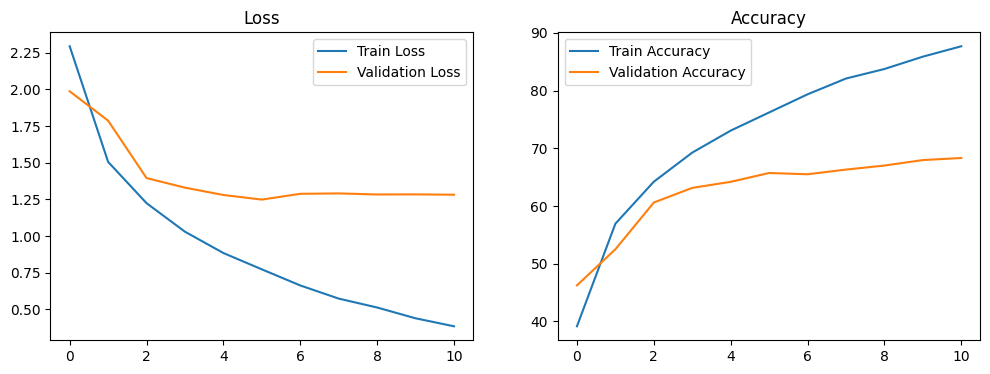

Training and evaluating resnet34


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 165MB/s]


Train Epoch: 0 [0/50000 (0%)]	Loss: 4.763359
Train Epoch: 0 [640/50000 (2%)]	Loss: 4.621120
Train Epoch: 0 [1280/50000 (3%)]	Loss: 4.131120
Train Epoch: 0 [1920/50000 (5%)]	Loss: 4.058887
Train Epoch: 0 [2560/50000 (6%)]	Loss: 3.883685
Train Epoch: 0 [3200/50000 (8%)]	Loss: 3.795808
Train Epoch: 0 [3840/50000 (10%)]	Loss: 3.805665
Train Epoch: 0 [4480/50000 (11%)]	Loss: 3.339161
Train Epoch: 0 [5120/50000 (13%)]	Loss: 3.662558
Train Epoch: 0 [5760/50000 (14%)]	Loss: 3.390536
Train Epoch: 0 [6400/50000 (16%)]	Loss: 3.262076
Train Epoch: 0 [7040/50000 (18%)]	Loss: 3.211233
Train Epoch: 0 [7680/50000 (19%)]	Loss: 3.225935
Train Epoch: 0 [8320/50000 (21%)]	Loss: 2.999033
Train Epoch: 0 [8960/50000 (22%)]	Loss: 3.092409
Train Epoch: 0 [9600/50000 (24%)]	Loss: 3.417712
Train Epoch: 0 [10240/50000 (26%)]	Loss: 3.149097
Train Epoch: 0 [10880/50000 (27%)]	Loss: 2.504725
Train Epoch: 0 [11520/50000 (29%)]	Loss: 2.716623
Train Epoch: 0 [12160/50000 (30%)]	Loss: 2.794864
Train Epoch: 0 [12800/5000

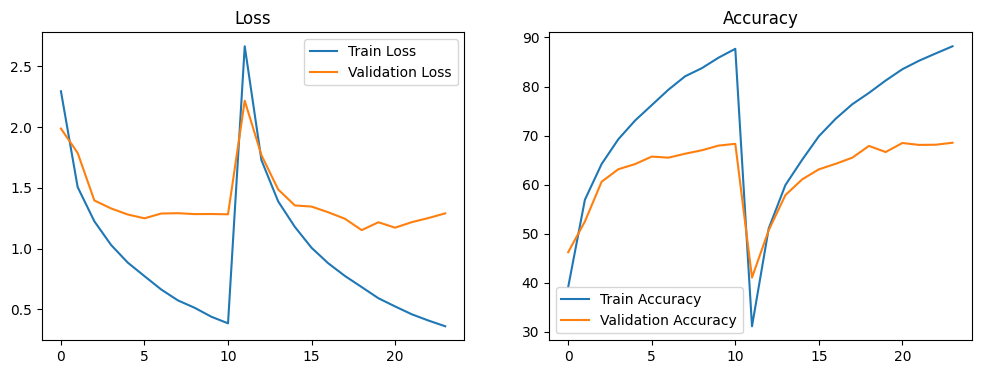

Training and evaluating resnet50


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 162MB/s]


Train Epoch: 0 [0/50000 (0%)]	Loss: 4.645671
Train Epoch: 0 [640/50000 (2%)]	Loss: 4.692839
Train Epoch: 0 [1280/50000 (3%)]	Loss: 4.681234
Train Epoch: 0 [1920/50000 (5%)]	Loss: 4.469138
Train Epoch: 0 [2560/50000 (6%)]	Loss: 4.465694
Train Epoch: 0 [3200/50000 (8%)]	Loss: 4.578732
Train Epoch: 0 [3840/50000 (10%)]	Loss: 3.986229
Train Epoch: 0 [4480/50000 (11%)]	Loss: 4.117761
Train Epoch: 0 [5120/50000 (13%)]	Loss: 4.064859
Train Epoch: 0 [5760/50000 (14%)]	Loss: 4.050051
Train Epoch: 0 [6400/50000 (16%)]	Loss: 4.004992
Train Epoch: 0 [7040/50000 (18%)]	Loss: 4.012806
Train Epoch: 0 [7680/50000 (19%)]	Loss: 3.977530
Train Epoch: 0 [8320/50000 (21%)]	Loss: 4.033495
Train Epoch: 0 [8960/50000 (22%)]	Loss: 3.901153
Train Epoch: 0 [9600/50000 (24%)]	Loss: 3.881437
Train Epoch: 0 [10240/50000 (26%)]	Loss: 3.663348
Train Epoch: 0 [10880/50000 (27%)]	Loss: 3.726397
Train Epoch: 0 [11520/50000 (29%)]	Loss: 3.831686
Train Epoch: 0 [12160/50000 (30%)]	Loss: 3.772958
Train Epoch: 0 [12800/5000

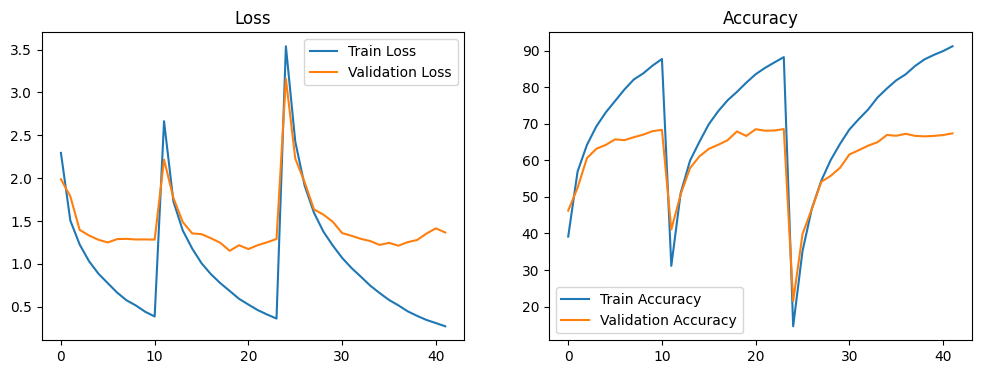

Training and evaluating resnet101


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 165MB/s] 


Train Epoch: 0 [0/50000 (0%)]	Loss: 4.629204
Train Epoch: 0 [640/50000 (2%)]	Loss: 4.721997
Train Epoch: 0 [1280/50000 (3%)]	Loss: 4.475463
Train Epoch: 0 [1920/50000 (5%)]	Loss: 4.449747
Train Epoch: 0 [2560/50000 (6%)]	Loss: 4.465024
Train Epoch: 0 [3200/50000 (8%)]	Loss: 4.513113
Train Epoch: 0 [3840/50000 (10%)]	Loss: 4.325446
Train Epoch: 0 [4480/50000 (11%)]	Loss: 4.178840
Train Epoch: 0 [5120/50000 (13%)]	Loss: 4.274667
Train Epoch: 0 [5760/50000 (14%)]	Loss: 4.186779
Train Epoch: 0 [6400/50000 (16%)]	Loss: 4.075395
Train Epoch: 0 [7040/50000 (18%)]	Loss: 4.187515
Train Epoch: 0 [7680/50000 (19%)]	Loss: 4.071139
Train Epoch: 0 [8320/50000 (21%)]	Loss: 4.331755
Train Epoch: 0 [8960/50000 (22%)]	Loss: 4.009648
Train Epoch: 0 [9600/50000 (24%)]	Loss: 4.307290
Train Epoch: 0 [10240/50000 (26%)]	Loss: 4.014493
Train Epoch: 0 [10880/50000 (27%)]	Loss: 3.928174
Train Epoch: 0 [11520/50000 (29%)]	Loss: 4.033232
Train Epoch: 0 [12160/50000 (30%)]	Loss: 4.016299
Train Epoch: 0 [12800/5000

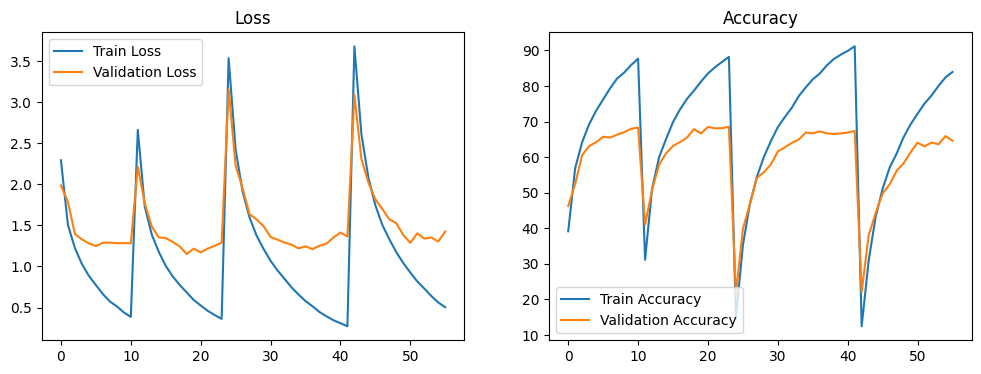

Training and evaluating resnet152


Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 170MB/s] 


Train Epoch: 0 [0/50000 (0%)]	Loss: 4.622487
Train Epoch: 0 [640/50000 (2%)]	Loss: 4.694795
Train Epoch: 0 [1280/50000 (3%)]	Loss: 4.570867
Train Epoch: 0 [1920/50000 (5%)]	Loss: 4.652611
Train Epoch: 0 [2560/50000 (6%)]	Loss: 4.624173
Train Epoch: 0 [3200/50000 (8%)]	Loss: 4.519215
Train Epoch: 0 [3840/50000 (10%)]	Loss: 4.434691
Train Epoch: 0 [4480/50000 (11%)]	Loss: 4.364280
Train Epoch: 0 [5120/50000 (13%)]	Loss: 4.178999
Train Epoch: 0 [5760/50000 (14%)]	Loss: 4.201422
Train Epoch: 0 [6400/50000 (16%)]	Loss: 4.077578
Train Epoch: 0 [7040/50000 (18%)]	Loss: 3.905941
Train Epoch: 0 [7680/50000 (19%)]	Loss: 3.881095
Train Epoch: 0 [8320/50000 (21%)]	Loss: 3.793773
Train Epoch: 0 [8960/50000 (22%)]	Loss: 4.137339
Train Epoch: 0 [9600/50000 (24%)]	Loss: 4.057811
Train Epoch: 0 [10240/50000 (26%)]	Loss: 3.970118
Train Epoch: 0 [10880/50000 (27%)]	Loss: 3.744689
Train Epoch: 0 [11520/50000 (29%)]	Loss: 3.743729
Train Epoch: 0 [12160/50000 (30%)]	Loss: 3.525374
Train Epoch: 0 [12800/5000

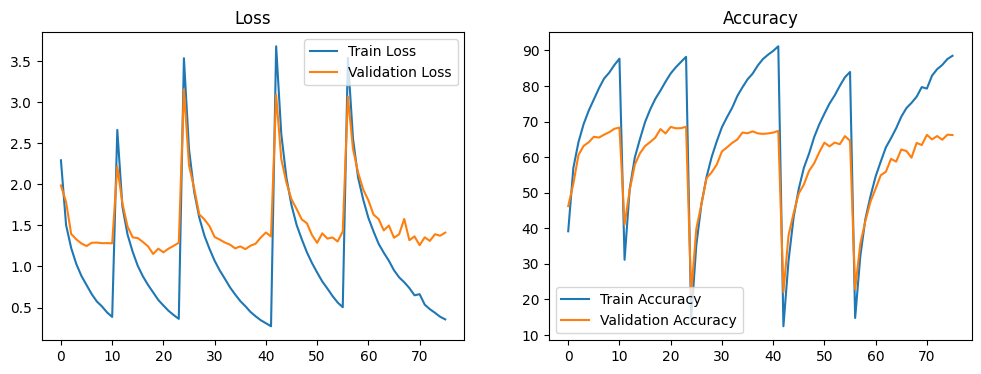

       Model  Train Accuracy  Validation Accuracy  Test Accuracy  \
0   resnet18         87.6850                68.32          68.05   
1   resnet34         88.2025                68.54          70.13   
2   resnet50         91.1650                67.36          69.36   
3  resnet101         83.9500                64.60          65.76   
4  resnet152         88.4925                66.21          67.69   

   Total Training Time (seconds)  
0                    2235.088516  
1                    5086.194780  
2                   11484.111718  
3                   18666.969807  
4                   32342.435969  


In [5]:
# Define number of classes according to your dataset
num_classes = 100  # CIFAR-100 has 100 classes

# Input jumlah epoch dan batch size
epochs = 200
batch_size = 64

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define data augmentation and loaders
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load CIFAR-100 dataset
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_val_test)

# Split training set into train and validation sets
train_indices, val_indices = train_test_split(list(range(len(trainset))), test_size=0.2, stratify=trainset.targets)
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

# Define DataLoaders
train_loader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
val_loader = DataLoader(trainset, batch_size=batch_size, sampler=val_sampler, num_workers=2)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Loss function
criterion = nn.CrossEntropyLoss()

# Training function
def train(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        if batch_idx % 10 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(inputs)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

        torch.cuda.empty_cache()

    accuracy = 100 * correct / total
    return running_loss / len(train_loader), accuracy

# Validation function
def validate(model, val_loader, criterion, device, epoch):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            if batch_idx % 10 == 0:
                print(f'Validation Epoch: {epoch} [{batch_idx * len(inputs)}/{len(val_loader.dataset)} ({100. * batch_idx / len(val_loader):.0f}%)]\tLoss: {loss.item():.6f}')

            torch.cuda.empty_cache()

    accuracy = 100 * correct / total
    print(classification_report(all_labels, all_predictions))
    return val_loss / len(val_loader), accuracy

# Early stopping
best_val_loss = float('inf')
patience = 5
patience_counter = 0

# Lists to store loss and accuracy values
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Timing variables
epoch_times = []
total_start_time = time.time()

# Function to convert seconds to hours, minutes, seconds
def convert_seconds(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return hours, minutes, seconds

# Training loop
def train_and_evaluate(model_name, num_epochs=epochs, patience=patience):
    model = create_resnet_model(model_name).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device, epoch)
        val_loss, val_acc = validate(model, val_loader, criterion, device, epoch)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Train Accuracy: {train_acc:.2f}%, Validation Loss: {val_loss:.6f}, Validation Accuracy: {val_acc:.2f}%")
        scheduler.step(val_loss)

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        epoch_times.append(epoch_duration)
        hours, minutes, seconds = convert_seconds(epoch_duration)
        print(f"Epoch {epoch+1} duration: {hours} hours, {minutes} minutes, {seconds} seconds")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f'best_{model_name}_cifar100.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

    total_end_time = time.time()
    total_duration = total_end_time - total_start_time
    total_hours, total_minutes, total_seconds = convert_seconds(total_duration)
    print(f"Total training time: {total_hours} hours, {total_minutes} minutes, {total_seconds} seconds")

    model.load_state_dict(torch.load(f'best_{model_name}_cifar100.pth'))

    # Evaluate model on test set
    def test(model, test_loader, device):
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

                torch.cuda.empty_cache()

        accuracy = 100 * correct / total
        return accuracy, all_predictions, all_labels

    test_accuracy, preds, true_labels = test(model, test_loader, device)
    print(f"Test Accuracy of {model_name}: {test_accuracy:.2f}%")
    print(classification_report(true_labels, preds))

    # Plotting training and validation loss and accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.show()

    return {
        "Model": model_name,
        "Train Accuracy": train_acc,
        "Validation Accuracy": val_acc,
        "Test Accuracy": test_accuracy,
        "Total Training Time (seconds)": total_duration
    }

# Train and evaluate all models
results = []
model_names = ["resnet18", "resnet34", "resnet50", "resnet101", "resnet152"]
for model_name in model_names:
    print(f"Training and evaluating {model_name}")
    result = train_and_evaluate(model_name, num_epochs=epochs, patience=patience)
    results.append(result)

# Create a DataFrame to display results
df = pd.DataFrame(results)
print(df)